# 

# PadeOpsIO overview
----------------

PadeOpsIO is a tool for loading, visualizing, and analyzing data from [PadeOps](https://github.com/Howland-Lab/PadeOps), an LES and DNS box code. 

Start with importing the code. Once installed from Github, import the module: 

In [1]:
import padeopsIO as pio

Several key classes and modules are automatically loaded when importing padeopsIO. These include: 

* `budgetIO.BudgetIO`: main interfacing class for loading and slicing into binary output files from PadeOps

* `deficitIO.DeficitIO`: main interfacing class for "deficit budgets" (base flow subtracted)

* `budget.Budget`: A class for easily computing budgets (e.g. RANS) offline from existing time-averaged statistics. 

* `budgetkey` and `deficitkey` modules: contain bi-directional dictionaries for matching the (budget, term) indexing from PadeOps with easy to interpret names ("ubar" is the time-averaged streamwise flow $\bar{u}$)


## The BudgetIO class
----------------------

The `budgetIO.py` file is the main submodule for loading files. Within `budgetIO.py`, the `BudgetIO` class imports PadeOps data into Python so it can be read and analyzed. 

### Reading from Fortran binaries

If reading directly from PadeOps output files, 

```python
sim = pio.BudgetIO(r"/path/to/data", padeops=True, runid=1)
```

The directory is expected to contain several files, namely: <br>
* an input file (Fortran namelist)`<FILENAME>.dat`  with matching RunID <br>
* Possibly a turbine directory which includes turbine files `ActuatorDisk_XXXX_input.inp` <br>
* Any associated output files from the simulation

Budgets (time-averaged fields) can be exported to numpy and other formats using the `write_data()` function. 

### Reading from python exports

If reading from data exported in `.npz` file format, 

```python
sim = pio.BudgetIO(r"/path/to/data", npz=True, filename="your_filename")
```

and expects the following files: <br>
* a metadata file `<FILENAME>_metadata.npz` <br>
* a data file `<FILENAME>_budgets.npz` <br>

When importing `.npz` files, if the filename is not the same as the directory name, specify the filename with the `filename=` keyword argument. In the cell below, we will import some data from `../test_data` that was exported to `.npz` file format from a previous simulation. 

In future version, PadeOpsIO will migrate all exported data to .nc NetCDF files (commonly used in climate science) and phase out the .npz file format. For now, .npz files are recommended. 

In [2]:
FILENAME = 'example'
DATA_DIR = r'../test_data'
sim = pio.BudgetIO(DATA_DIR, filename=FILENAME, npz=True)
print(sim)

Now `sim` is a `BudgetIO` object that refers to an object that references the exported data saved in `../test_data/example_budgets.npz` with metadata stored in `../test_data/example_metadata.npz`. We can show the metadata from the input file by printing `sim.input_nml` ("nml" short for "namelist"; this is the file that was originally input to the Fortran code, stored as a Python dictionary). The full input file is very long, let's just print the namelists it contains: 

In [9]:
print("Namelist keys: ", sim.input_nml.keys())

Namelist keys:  dict_keys(['input', 'numerics', 'io', 'stats', 'os_interactions', 'physics', 'pressure_calc', 'bcs', 'fringe', 'sgs_model', 'windturbines', 'kspreprocess', 'control', 'problem_input', 'budget_time_avg', 'budget_xy_avg'])


## Loading data
--------------
Let's load some data from the budgets file. We can load entire (time-averaged) budgets of the full flow field, or of just a "slice" (either 1D, 2D, or 3D) through some of the flow field. Typically, the computational domain is much larger than the domain of interest, so let's just load a 3D slice cut into the full domain. 

(For loading full budgets, see `sim.read_budgets()`)

We can see what quantities we have access to by calling `sim.existing_terms()`. Then we create a "slice" of the existing data (here, just time-averaged velocity fields were saved) with the function `slice()`. 

In [4]:
print("Existing terms in .npz file: ", sim.existing_terms())

ds = sim.slice(budget_terms=['ubar'], xlim=[-2, 12], ylim=[-2, 2], zlim=0)
print(ds.keys())

Existing terms in .npz file:  ['ubar', 'wbar', 'vbar']
KeysView(<xarray.GridDataset> Size: 93kB
Dimensions:  (x: 141, y: 81)
Coordinates:
  * x        (x) float64 1kB -2.0 -1.9 -1.8 -1.7 -1.6 ... 11.7 11.8 11.9 12.0
  * y        (y) float64 648B -2.0 -1.95 -1.9 -1.85 -1.8 ... 1.85 1.9 1.95 2.0
    z        float64 8B -0.025
Data variables:
    ubar     (x, y) float64 91kB 0.8919 0.8913 0.8913 ... 0.9121 0.9133 0.9142)


Now we have an xarray Dataset with a 2D array `'ubar'`. The custom class `GridDataset` is a standard xarray Dataset containing the DataArray "ubar" with coordinate axes for `'x'`, `'y'`, and `'z'`. The grid can be accessed through the custom `grid` attribute. Here, `zlim=0` means that `z` is just a scalar, but because `xlim` and `ylim` are ranges, `x` and `y` will be arrays. Note that $z = -0.025$ and not exactly zero because the custom function slice and xarray function select both retain the original datapoints without any interpolation, and $z=-0.025$ is the nearest grid point to the requested value of $z=0$. 

We can plot this 2D field as an image. DataArrays have a built-in `.plot()` function: 

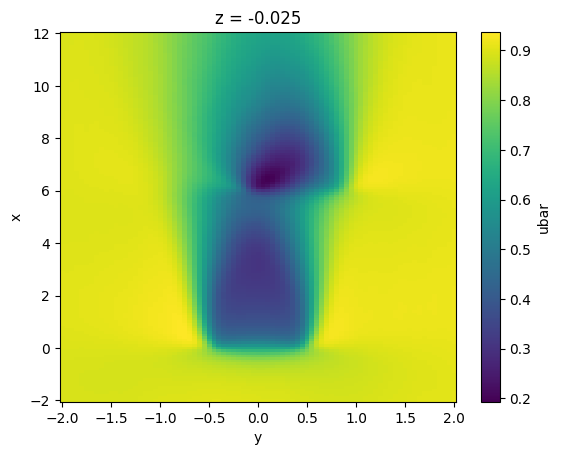

In [5]:
ds['ubar'].plot()

Whoops! This is supposed to be two wind turbine wakes, so we need to fix some things. 
1. Fortran indexes in ijk format (instead of xy format), so if we are displaying data with `plt.imshow` (as xarray's default 2D plotter does), the array needs to be transposed.
2. We can set the extents of the image to correspond with the physical domain by using the `extent` keyword.
3. Add labels to make the plot. There is a dictionary returned by `pio.budgetkey.key_labels()` that matches the keys used in the budgets and slices for field variables with appropriate variable names (e.g. `'ubar'` matches to $\bar{u}/U$). 

Coded up, this would look like:

```python
import matplotlib.pyplot as plt
keylab = pio.budgetkey.key_labels()

fig, ax = plt.subplots()
im = ax.imshow(ds['ubar'].T, extent=ds['extent'], origin='lower')

ax.set_xlabel(keylab['x'])
ax.set_ylabel(keylab['y'])
plt.colorbar(im, label=keylab['ubar'])  # adds a colorbar
```

Because plotting 2D fields is something done *all the time* when analyzing LES data, this has been built as a custom attribute to DataArrays in the gridslice module, which is automatically loaded with PadeOpsIO: 

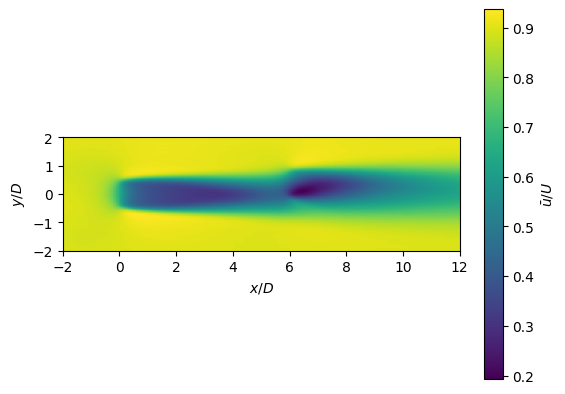

In [6]:
ds['ubar'].imshow()

That looks much better. 

Calling `sim.slice` loads the budgets automatically because they are needed to construct the slice. Once budgets are loaded, they stay loaded in the `budget` field of the `BudgetIO` object. We can access the same data as in the plot above from the budget dictionary in the object variables. Budgets can also be loaded into the BudgetIO attribute `sim.budget` by calling `sim.read_budgets(budget_terms=['ubar'])`. We can take vertical slices, as well as 1D or 0D slices (i.e. lines and points). Slices can also be of instantaneous fields if the `field_terms` keyword argument is used. 

We can check the total extent of the domain from the `sim.grid` attribute, which simply points to `sim.budget.grid`: 

In [7]:
print("Exported extent: ", sim.grid.extent)
print("nx, ny, nz:", sim.grid.nxi)  # prints sim.grid.nx, sim.grid.ny, sim.grid.nz

Exported extent:  [-2.    15.    -2.     2.    -0.975  0.975]
nx, ny, nz: [171  81  40]


## Final note: reading power
-------------------------------
To wrap up this quickstart guide, we will read the turbine properties (power, for example) of the leading and trailing turbines. These are normalized to LES "code" units, which we could dimensionalize by multiplying by $D^2 U^3$. Here, we instead nromalize to power coefficient $C_P = P/(\tfrac 12 \rho A_d u_\infty^3)$. Note that the power begins very large ($C_P \gg 16/27 =$ Betz) because the transient behavior of adding the wind turbines into an otherwise undisturbed flow is included in the start of these time series. 

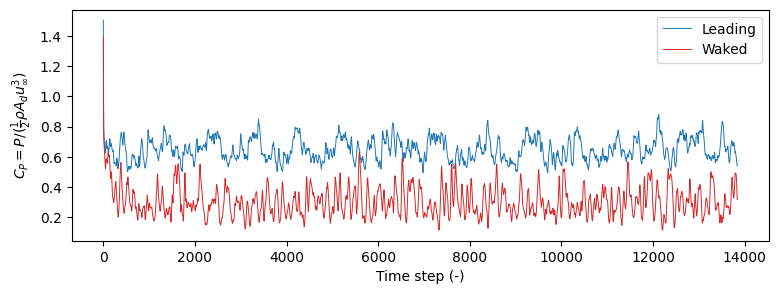

In [8]:
import matplotlib.pyplot as plt
import numpy as np

power_t1 = sim.read_turb_power(turb=1)  # leading turbine
power_t2 = sim.read_turb_power(turb=2)  # trailing turbine
u_inf = sim.slice(budget_terms=['ubar'], xlim=-5, zlim=0)['ubar'].mean("y").values

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(power_t1 / (0.5 * np.pi * 0.5**2 * u_inf**3), label='Leading', lw=0.7)
ax.plot(power_t2 / (0.5 * np.pi * 0.5**2 * u_inf**3), label='Waked', lw=0.7, color='tab:red')
ax.legend()
ax.set_xlabel('Time step (-)')
ax.set_ylabel('$C_P = P/(\\frac {1}{2} \\rho A_d u_\\infty^3$)')
plt.show()